In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost

%matplotlib inline

# Import data
data = pd.read_csv('../data/data_all_features.csv')
minimal_data = pd.read_csv('../data/data_selected_features.csv')
train_test_data = pickle.load(open("../data/train_test_data_all_features", "rb"))
minimal_train_test_data = pickle.load(open("../data/train_test_data_selected_features", "rb"))
model = pickle.load(open("../data/xgb_model_pickle_v2", "rb"))

# Get samples
sample_data = train_test_data['X_test'].assign(show_up = train_test_data['y_test']).reset_index(drop=True)
minimal_sample_data = minimal_train_test_data['X_test'].assign(show_up = minimal_train_test_data['y_test']).reset_index(drop=True)

np.random.seed(42)
indices = np.random.randint(0, len(train_test_data['y_test']), 10)
sample = sample_data.loc[indices]
minimal_sample = minimal_sample_data.loc[indices]

zero_sample = minimal_train_test_data['X_test'].assign(show_up = minimal_train_test_data['y_test']).reset_index(drop = True)
zero_sample = zero_sample[zero_sample['show_up'] == 0].reset_index(drop = True)

X_train = minimal_train_test_data['X_train']
X_test = minimal_train_test_data['X_test']
y_train = minimal_train_test_data['y_train']
y_test = minimal_train_test_data['y_test']
X_test_zero = zero_sample.drop('show_up', axis=1)
y_test_zero = zero_sample.loc[:, 'show_up']
y_test_zero[0] = 1 # Inserts an 1 so that doesn't mess with metrics

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [60]:
from sklearn.metrics import make_scorer, f1_score, fbeta_score
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=1000, n_jobs=4, silent=False, max_depth=3, learning_rate=0.3)

def custom_eval(y_pred, y_true):
    labels = y_true.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y_pred]
    # return 'f1_score', f1_score(labels, y_bin)
    return 'fbeta_score', 1 - fbeta_score(labels, y_bin, beta=0.5)

model = clf.fit(minimal_train_test_data['X_train'], 
                minimal_train_test_data['y_train'], 
                eval_set=[(minimal_train_test_data['X_test'], minimal_train_test_data['y_test'])], 
                eval_metric=custom_eval, 
                early_stopping_rounds=100, 
                verbose=True)

[0]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
Multiple eval metrics have been passed: 'validation_0-fbeta_score' will be used for early stopping.

Will train until validation_0-fbeta_score hasn't improved in 100 rounds.
[1]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[2]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[3]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[4]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[5]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[6]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[7]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[8]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[9]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[10]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[11]	validation_0-error:0.30108	validation_0-fbeta_score:0.256297
[12]	validation_0-error:0.30108	validation_0

In [61]:
# Define cutoff for probabilities
cutoff = 0.7

# Calculates predictions for X_test
pred = model.predict(X_test)
prob = np.array([i[1] for i in model.predict_proba(X_test)])
prob_bin = np.array([1.0 if p > cutoff else 0.0 for p in prob])

# Calculates predictions for X_test_zero
pred_zero = model.predict(X_test_zero)
prob_zero = np.array([i[1] for i in model.predict_proba(X_test_zero)])
prob_bin_zero = np.array([1.0 if p > cutoff else 0.0 for p in prob_zero])

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(pred, y_test))
print(confusion_matrix(pred, y_test))
print('-' * 60)
print(classification_report(pred_zero, y_test_zero))
print(confusion_matrix(pred_zero, y_test_zero))

              precision    recall  f1-score   support

           0       0.01      0.53      0.02       367
           1       1.00      0.70      0.82     74633

   micro avg       0.70      0.70      0.70     75000
   macro avg       0.50      0.61      0.42     75000
weighted avg       0.99      0.70      0.82     75000

[[  193   174]
 [22388 52245]]
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.01      1.00      0.02       193
           1       1.00      0.00      0.00     22388

   micro avg       0.01      0.01      0.01     22581
   macro avg       0.50      0.50      0.01     22581
weighted avg       0.99      0.01      0.00     22581

[[  193     0]
 [22387     1]]


In [66]:
from sklearn.metrics import fbeta_score
print('fbeta_score zero:')
print(fbeta_score(prob_bin_zero, y_test_zero, beta=0.5))
print('\nfbeta_score all:')
print(fbeta_score(prob_bin, y_test, beta=0.5))

fbeta_score zero:
0.000532481363152

fbeta_score all:
0.590148885972


Confusion matrix, without normalization
[[  101 22480]
 [  102 52317]]


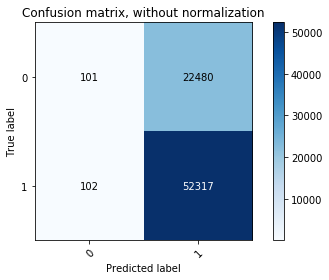

In [56]:
plot_confusion_matrix(np.array(y_test), pred, classes=np.array([0, 1]))

Confusion matrix, without normalization
[[  101 22479]
 [    0     1]]


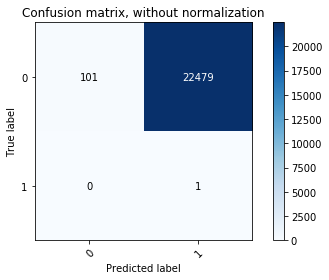

In [57]:
plot_confusion_matrix(np.array(y_test_zero), pred_zero, classes=np.array([0, 1]))

In [48]:
from sklearn import svm, datasets
a = datasets.load_iris()

In [52]:
a.target_names[[0, 1, 2]]

array(['setosa', 'versicolor', 'virginica'], 
      dtype='<U10')

In [30]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Feature Selection

<BarContainer object of 19 artists>

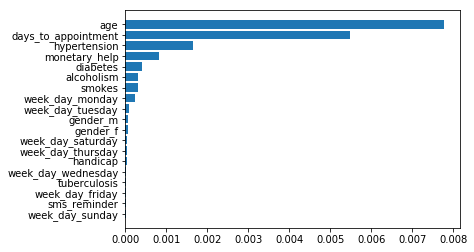

In [2]:
from helper import intersect_features
from sklearn.feature_selection import mutual_info_classif

discrete_idx = [i for i in range(2, 19)]
selection_scores = mutual_info_classif(train_test_data['X_train'], train_test_data['y_train'], discrete_idx)
mi_table = pd.DataFrame({'var': train_test_data['X_train'].columns, 'mi': selection_scores}).sort_values('mi', ascending=True)

plt.barh(mi_table['var'], mi_table['mi'])

<BarContainer object of 19 artists>

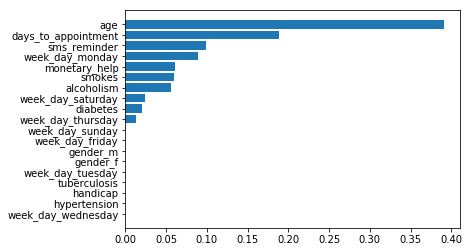

In [3]:
selection_table = pd.DataFrame({'var': train_test_data['X_train'].columns, 'mi': model.feature_importances_}).sort_values('mi', ascending=True)

plt.barh(selection_table['var'], selection_table['mi'])

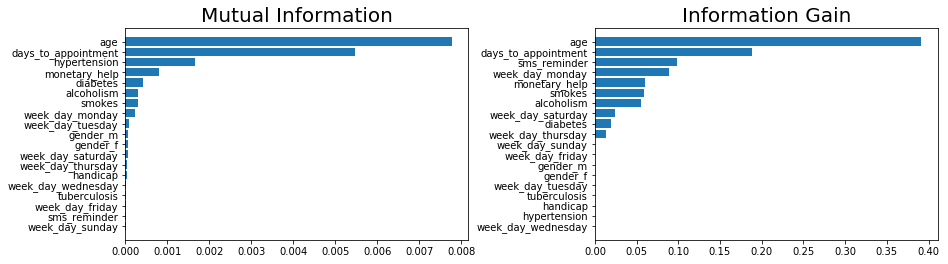

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(13, 3.5))
ax[0].barh(mi_table['var'], mi_table['mi'])
ax[0].set_title('Mutual Information', fontsize=20)
ax[1].barh(selection_table['var'], selection_table['mi'])
ax[1].set_title('Information Gain', fontsize=20)
plt.tight_layout(pad=0.1)#, w_pad=0.5, h_pad=1.0)